In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Import segmentation models (install via pip if needed)
import segmentation_models_pytorch as smp

# =============================================================================
# 1. Dataset Definition
# =============================================================================
class LungSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        self.image_names = sorted(os.listdir(images_dir))
        self.mask_names = sorted(os.listdir(masks_dir))
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_names[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_names[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale
        
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        # Ensure mask is binary: thresholding values > 0.5
        mask = (mask > 0.5).float()
        return image, mask

# =============================================================================
# 2. Transforms & Data Loaders
# =============================================================================
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Dataset directories (adjust paths as needed)
train_img_dir = r"train\augmented_scans"
train_mask_dir = r"train\augmented_masks"
val_img_dir   = r"valid_2\origin_2"
val_mask_dir  = r"valid_2\mask_2"
test_img_dir  = r"test_2\origin_2"
test_mask_dir = r"test_2\mask_2"

train_dataset = LungSegmentationDataset(train_img_dir, train_mask_dir, image_transform=transform_image, mask_transform=transform_mask)
val_dataset   = LungSegmentationDataset(val_img_dir, val_mask_dir, image_transform=transform_image, mask_transform=transform_mask)
test_dataset  = LungSegmentationDataset(test_img_dir, test_mask_dir, image_transform=transform_image, mask_transform=transform_mask)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=True)

# =============================================================================
# 3. Model, Loss, and Optimizer
# =============================================================================
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# =============================================================================
# 4. Evaluation Metrics Definitions
# =============================================================================
def compute_rmse(pred, mask):
    mse = torch.mean((pred - mask) ** 2)
    return torch.sqrt(mse)

def compute_dice(pred, mask, threshold=0.5):
    pred = (pred > threshold).float()
    smooth = 1e-6
    intersection = (pred * mask).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + mask.sum(dim=(1,2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def compute_iou(pred, mask, threshold=0.5):
    pred = (pred > threshold).float()
    smooth = 1e-6
    intersection = (pred * mask).sum(dim=(1,2,3))
    union = (pred + mask - pred * mask).sum(dim=(1,2,3))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

def compute_precision_recall_f1(pred, mask, threshold=0.5):
    pred_bin = (pred > threshold).float()
    eps = 1e-6
    tp = (pred_bin * mask).sum(dim=(1,2,3))
    fp = (pred_bin * (1 - mask)).sum(dim=(1,2,3))
    fn = ((1 - pred_bin) * mask).sum(dim=(1,2,3))
    
    precision = (tp + eps) / (tp + fp + eps)
    recall    = (tp + eps) / (tp + fn + eps)
    f1_score  = 2 * precision * recall / (precision + recall + eps)
    return precision.mean().item(), recall.mean().item(), f1_score.mean().item()

# =============================================================================
# 5. Training and Validation Loop
# =============================================================================
num_epochs = 100
train_losses, val_losses = [], []
val_dices, val_ious, val_rmse = [], [], []
val_precs, val_recalls, val_f1s = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    dice_score_sum, iou_score_sum, rmse_score_sum = 0.0, 0.0, 0.0
    prec_sum, rec_sum, f1_sum = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_val_loss += loss.item() * images.size(0)
            
            preds = torch.sigmoid(outputs)
            dice_score_sum += compute_dice(preds, masks) * images.size(0)
            iou_score_sum  += compute_iou(preds, masks) * images.size(0)
            rmse_score_sum += compute_rmse(preds, masks).item() * images.size(0)
            
            p, r, f = compute_precision_recall_f1(preds, masks)
            prec_sum += p * images.size(0)
            rec_sum  += r * images.size(0)
            f1_sum   += f * images.size(0)
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_dice     = dice_score_sum / len(val_loader.dataset)
    epoch_iou      = iou_score_sum / len(val_loader.dataset)
    epoch_rmse     = rmse_score_sum / len(val_loader.dataset)
    epoch_prec     = prec_sum / len(val_loader.dataset)
    epoch_rec      = rec_sum / len(val_loader.dataset)
    epoch_f1       = f1_sum / len(val_loader.dataset)
    
    val_losses.append(epoch_val_loss)
    val_dices.append(epoch_dice)
    val_ious.append(epoch_iou)
    val_rmse.append(epoch_rmse)
    val_precs.append(epoch_prec)
    val_recalls.append(epoch_rec)
    val_f1s.append(epoch_f1)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | "
          f"Dice: {epoch_dice:.4f}, IoU: {epoch_iou:.4f}, RMSE: {epoch_rmse:.4f} | "
          f"Prec: {epoch_prec:.4f}, Rec: {epoch_rec:.4f}, F1: {epoch_f1:.4f}")

# =============================================================================
# 6. Save Model Weights
# =============================================================================
weights_path = "model_weights_Resnet50.pth"
torch.save(model.state_dict(), weights_path)
print(f"Model weights saved to {weights_path}")


e:\anaconda\Anaconda\envs\torchgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/100 | Train Loss: 0.3077, Val Loss: 0.1220 | Dice: 0.0000, IoU: 0.0000, RMSE: 0.1195 | Prec: 0.9388, Rec: 0.0000, F1: 0.0000
Epoch 2/100 | Train Loss: 0.0761, Val Loss: 0.0463 | Dice: 0.0105, IoU: 0.0055, RMSE: 0.0526 | Prec: 0.9767, Rec: 0.0055, F1: 0.0105
Epoch 3/100 | Train Loss: 0.0337, Val Loss: 0.0238 | Dice: 0.4439, IoU: 0.3563, RMSE: 0.0329 | Prec: 0.9387, Rec: 0.3807, F1: 0.4439
Epoch 4/100 | Train Loss: 0.0185, Val Loss: 0.0139 | Dice: 0.6050, IoU: 0.5293, RMSE: 0.0230 | Prec: 0.9217, Rec: 0.5802, F1: 0.6050
Epoch 5/100 | Train Loss: 0.0114, Val Loss: 0.0091 | Dice: 0.6437, IoU: 0.5725, RMSE: 0.0189 | Prec: 0.9200, Rec: 0.6310, F1: 0.6437
Epoch 6/100 | Train Loss: 0.0077, Val Loss: 0.0062 | Dice: 0.6804, IoU: 0.6110, RMSE: 0.0161 | Prec: 0.9251, Rec: 0.6725, F1: 0.6804
Epoch 7/100 | Train Loss: 0.0054, Val Loss: 0.0045 | Dice: 0.7092, IoU: 0.6390, RMSE: 0.0149 | Prec: 0.9314, Rec: 0.6957, F1: 0.7092
Epoch 8/100 | Train Loss: 0.0040, Val Loss: 0.0035 | Dice: 0.7209, Io

In [3]:

# Print final evaluation metrics on validation set
print("Final Evaluation on Validation Set:")
print(f"Val Loss: {val_losses[-1]:.4f}")
print(f"Dice: {val_dices[-1]:.4f}, IoU: {val_ious[-1]:.4f}, RMSE: {val_rmse[-1]:.4f}")
print(f"Precision: {val_precs[-1]:.4f}, Recall: {val_recalls[-1]:.4f}, F1: {val_f1s[-1]:.4f}")


Final Evaluation on Validation Set:
Val Loss: 0.0013
Dice: 0.8021, IoU: 0.7271, RMSE: 0.0140
Precision: 0.8893, Recall: 0.8112, F1: 0.8021


In [4]:

# =============================================================================
# 7. Test Evaluation & Visualization of Sample Predictions
# =============================================================================
model.eval()
test_images, test_masks, test_preds = [], [], []
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        
        test_images.append(images.cpu())
        test_masks.append(masks.cpu())
        test_preds.append(preds.cpu())



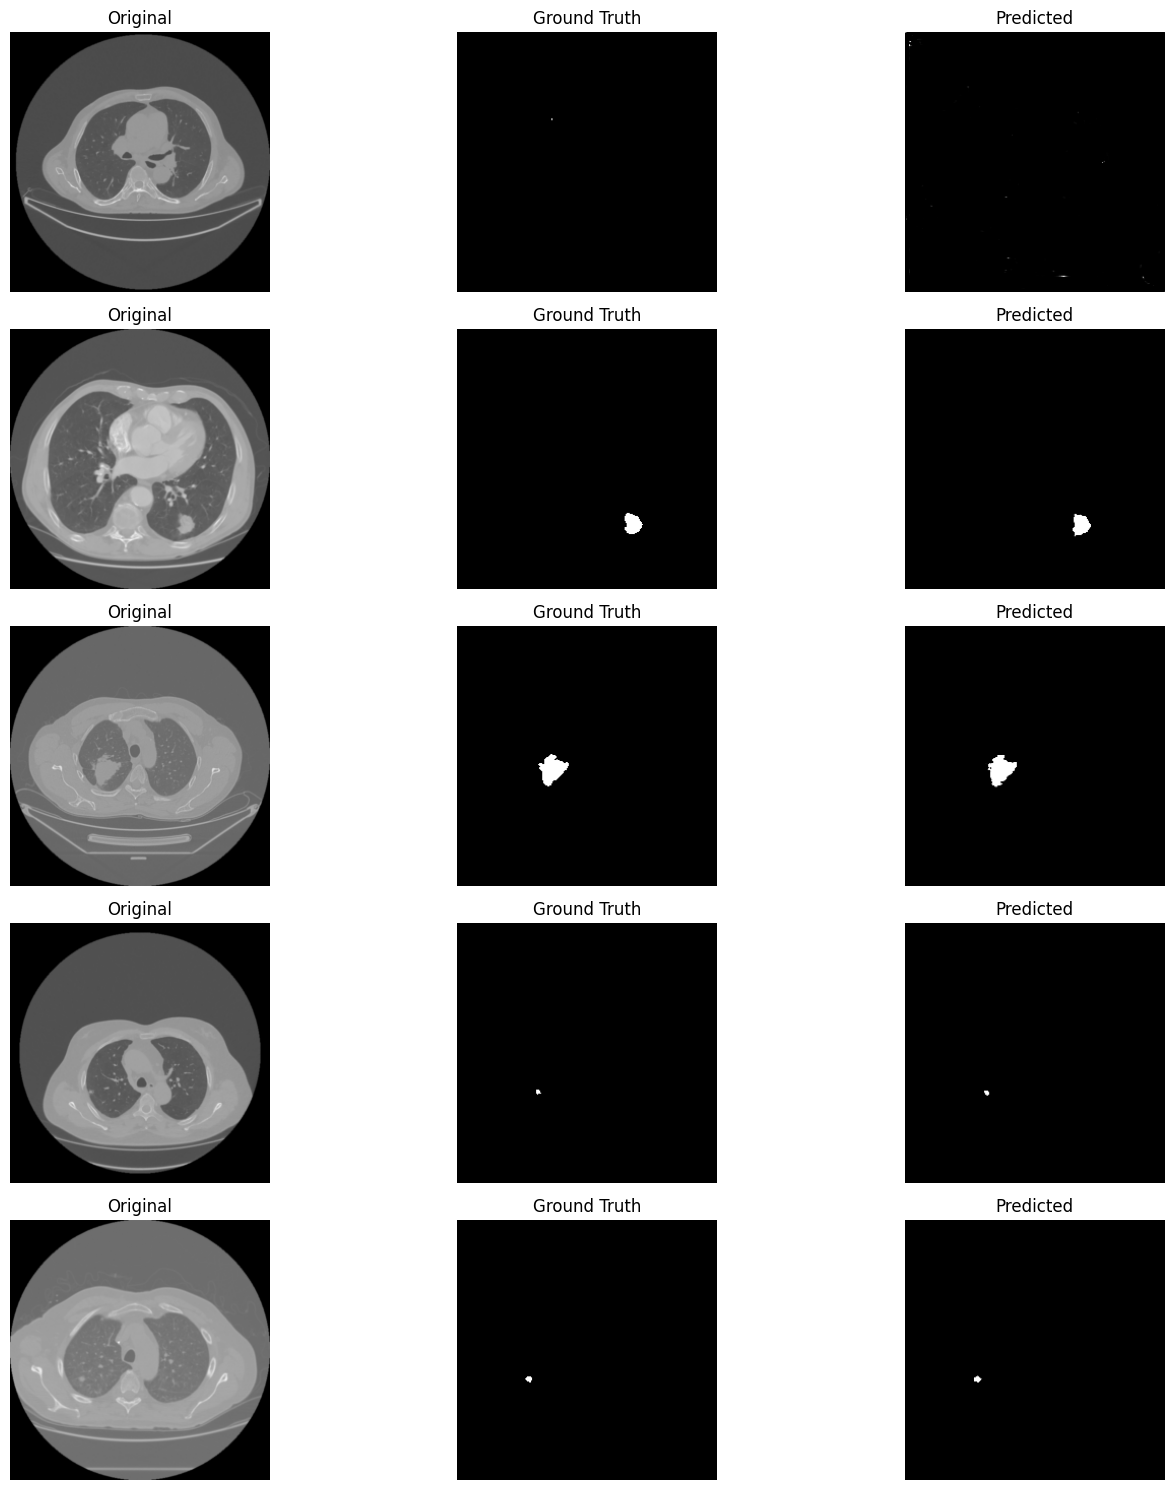

In [5]:

# Visualize 5 random test samples: Original, Ground Truth, and Predicted Mask
num_samples = 5
indices = random.sample(range(len(test_images)), num_samples)

plt.figure(figsize=(15, num_samples * 3))
for i, idx in enumerate(indices):
    # Since test loader uses batch size 1, extract the single image
    image = test_images[idx][0].permute(1, 2, 0).numpy()
    mask = test_masks[idx][0].squeeze().numpy()
    pred = test_preds[idx][0].squeeze().numpy()
    
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Predicted")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

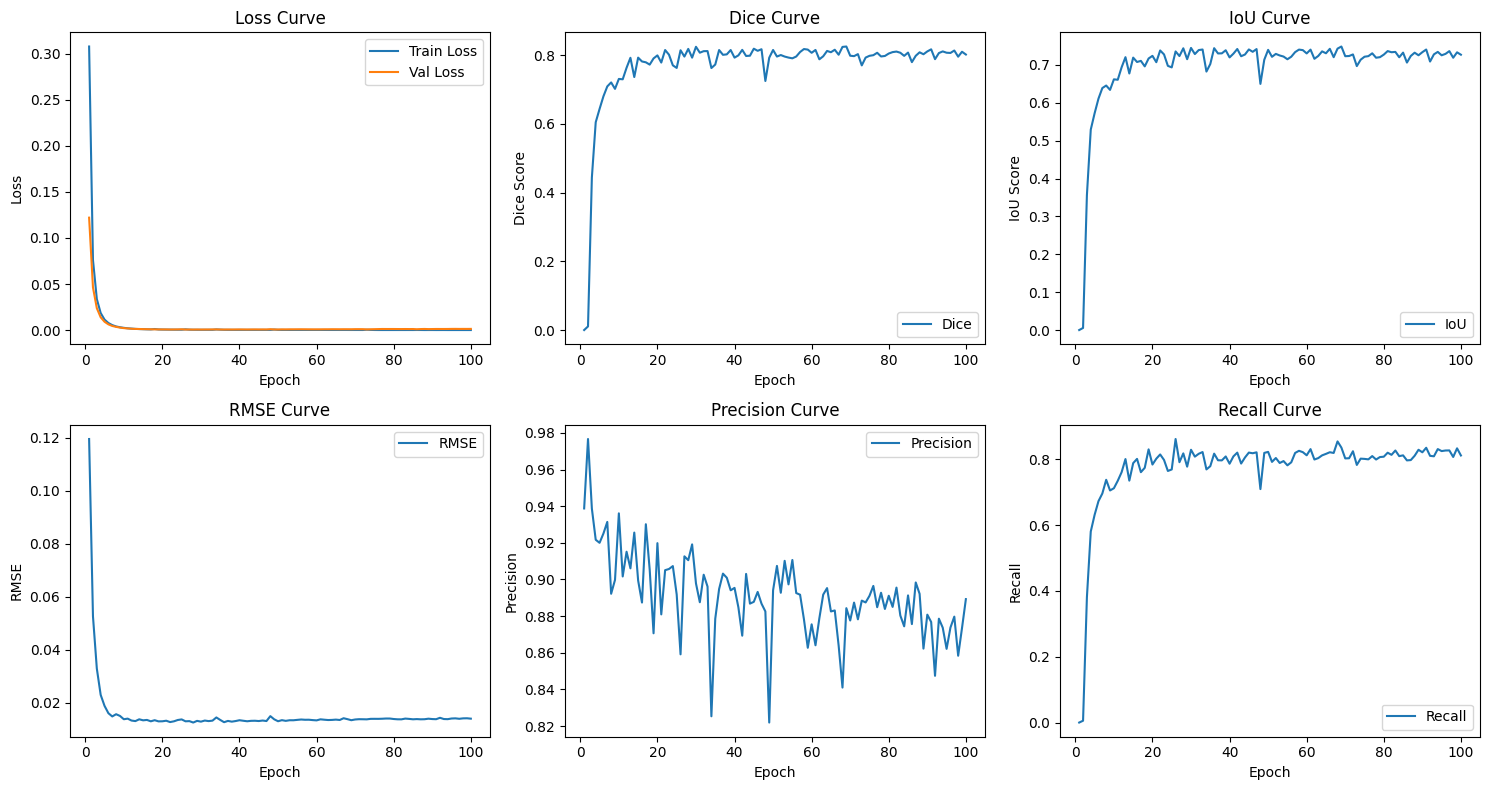

In [6]:

# Optionally, plot training curves for loss and metrics
epochs = range(1, num_epochs+1)
plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(2, 3, 2)
plt.plot(epochs, val_dices, label="Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.title("Dice Curve")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_ious, label="IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.legend()
plt.title("IoU Curve")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_rmse, label="RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.title("RMSE Curve")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_precs, label="Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision Curve")

plt.subplot(2, 3, 6)
plt.plot(epochs, val_recalls, label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.title("Recall Curve")

plt.tight_layout()
plt.show()


In [7]:
# =============================================================================
# 7. Final Evaluation on Test Set
# =============================================================================
model.eval()
test_dice_sum, test_iou_sum, test_rmse_sum = 0.0, 0.0, 0.0
test_prec_sum, test_rec_sum, test_f1_sum = 0.0, 0.0, 0.0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        preds = torch.sigmoid(outputs)
        test_dice_sum += compute_dice(preds, masks) * images.size(0)
        test_iou_sum  += compute_iou(preds, masks) * images.size(0)
        test_rmse_sum += compute_rmse(preds, masks).item() * images.size(0)
        
        p, r, f = compute_precision_recall_f1(preds, masks)
        test_prec_sum += p * images.size(0)
        test_rec_sum  += r * images.size(0)
        test_f1_sum   += f * images.size(0)

test_dice_avg = test_dice_sum / len(test_loader.dataset)
test_iou_avg  = test_iou_sum / len(test_loader.dataset)
test_rmse_avg = test_rmse_sum / len(test_loader.dataset)
test_prec_avg = test_prec_sum / len(test_loader.dataset)
test_rec_avg  = test_rec_sum / len(test_loader.dataset)
test_f1_avg   = test_f1_sum / len(test_loader.dataset)

print("Final Evaluation on Test Set:")
print(f"Dice: {test_dice_avg:.4f}, IoU: {test_iou_avg:.4f}, RMSE: {test_rmse_avg:.4f}")
print(f"Precision: {test_prec_avg:.4f}, Recall: {test_rec_avg:.4f}, F1: {test_f1_avg:.4f}")


Final Evaluation on Test Set:
Dice: 0.7558, IoU: 0.6754, RMSE: 0.0147
Precision: 0.8419, Recall: 0.7760, F1: 0.7558


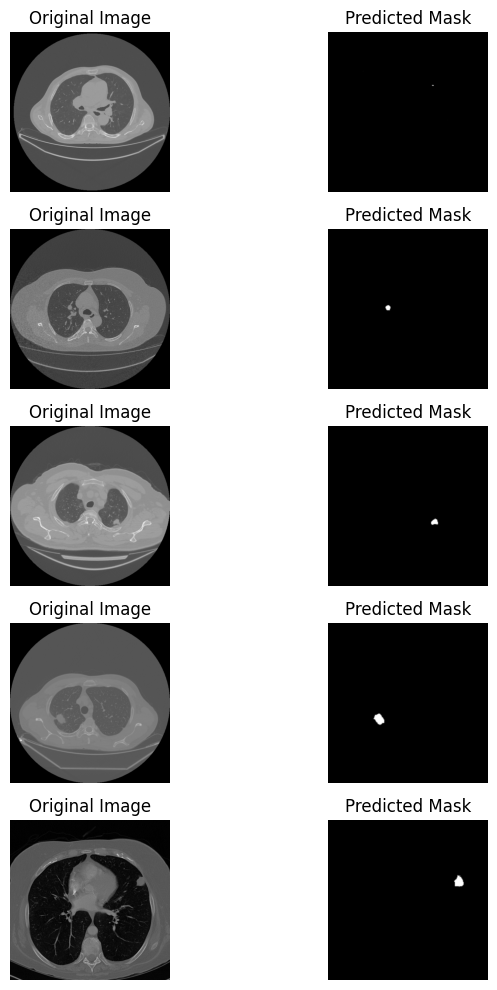

In [9]:
import cv2
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,  # Set to None since we're loading trained weights
    in_channels=3,
    classes=1
).to(device)
model.load_state_dict(torch.load("model_weights_Resnet50.pth", map_location=device))
model.eval()

# Define image folder
image_folder = "origin"
image_filenames = ["image_1.png", "image_2.png", "image_3.png", "image_7.png", "image_9.png"]

# Define transformation function (resize to model input size)
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0  # Normalize
    image = np.transpose(image, (2, 0, 1))  # Change to (C, H, W)
    return torch.tensor(image).unsqueeze(0).to(device)

# Visualization
fig, axes = plt.subplots(len(image_filenames), 2, figsize=(8, 10))

for i, img_name in enumerate(image_filenames):
    img_path = os.path.join(image_folder, img_name)

    # Load and preprocess image
    input_tensor = preprocess_image(img_path)

    # Predict segmentation mask
    with torch.no_grad():
        pred_mask = model(input_tensor)
        pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()  # Apply sigmoid and convert to numpy

    # Resize back to original dimensions for better visualization
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    pred_mask_resized = cv2.resize(pred_mask, (original_img.shape[1], original_img.shape[0]))

    # Plot images
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(pred_mask_resized, cmap="gray")
    axes[i, 1].set_title("Predicted Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


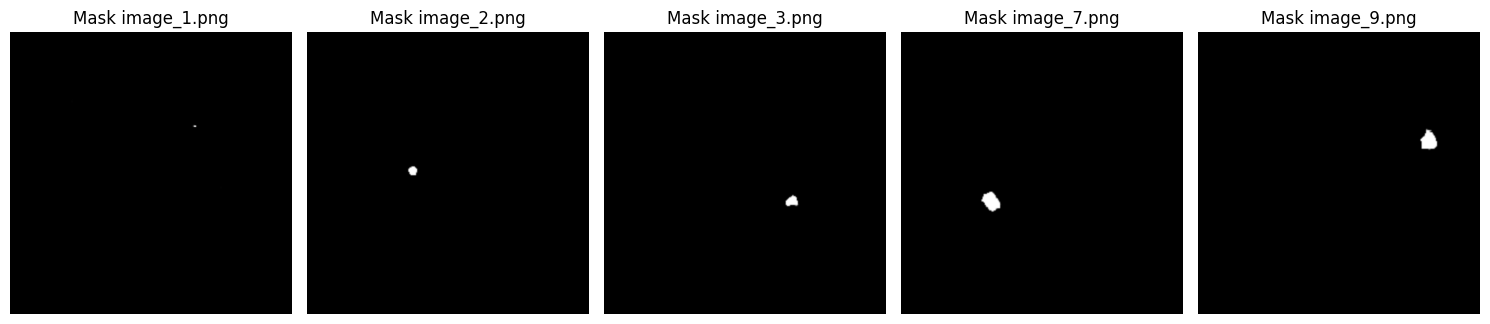

In [11]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=1
).to(device)
model.load_state_dict(torch.load("model_weights_Resnet50.pth", map_location=device))
model.eval()

# Define image folder and filenames
image_folder = "origin"
image_filenames = ["image_1.png", "image_2.png", "image_3.png", "image_7.png", "image_9.png"]

# Preprocess function
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0  # Normalize
    image = np.transpose(image, (2, 0, 1))  # Change to (C, H, W)
    return torch.tensor(image).unsqueeze(0).to(device)

# Visualization
fig, axes = plt.subplots(1, len(image_filenames), figsize=(15, 5))

for i, img_name in enumerate(image_filenames):
    img_path = os.path.join(image_folder, img_name)

    # Load and preprocess image
    input_tensor = preprocess_image(img_path)

    # Predict segmentation mask
    with torch.no_grad():
        pred_mask = model(input_tensor)
        pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()  # Apply sigmoid and convert to numpy

    # Resize mask to original image size
    original_img = cv2.imread(img_path)
    pred_mask_resized = cv2.resize(pred_mask, (original_img.shape[1], original_img.shape[0]))

    # Plot predicted mask
    axes[i].imshow(pred_mask_resized, cmap="gray")
    axes[i].set_title(f"Mask {img_name}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()
